<a href="https://colab.research.google.com/github/jpatra72/irt-Hiwi/blob/main/pseudoRange_Estimation-Model_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
from google.colab import files

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchsummary import summary

from tqdm import tnrange, notebook, tqdm

import os.path
from datetime import datetime
from pytz import timezone, all_timezones
from pathlib import Path

In [ ]:
gpu_avail = torch.cuda.is_available()
print(f"Is the GPU available? {gpu_avail}")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Is the GPU available? True
Device cuda


In [ ]:
drive.mount('/content/drive')
path = Path('/content/drive/MyDrive/Colab_Notebooks/HiWi/dataset/SVData-22_08_05-13_24_42-v1.01.csv')
dfOrignal = pd.read_csv(path)
path = Path('/content/drive/MyDrive/Colab_Notebooks/HiWi/results/model3')
# drive.flush_and_unmount()



Mounted at /content/drive


In [ ]:
from google.colab import data_table

pd.options.display.max_columns = 80

data_table.enable_dataframe_formatter()
dfMod = dfOrignal.drop(columns='TimeStamp')
dfMod.head()

,SV_Count_Per_Epoch,gnssSvidTracked_SV1,gnssCN0_SV1,gnssPrEpsilon_SV1,gnssPseudorangeRSS_SV1,gnssAzimuth_SV1,gnssElevation_SV1,gnssSvidTracked_SV2,gnssCN0_SV2,gnssPrEpsilon_SV2,gnssPseudorangeRSS_SV2,gnssAzimuth_SV2,gnssElevation_SV2,gnssSvidTracked_SV3,gnssCN0_SV3,gnssPrEpsilon_SV3,gnssPseudorangeRSS_SV3,gnssAzimuth_SV3,gnssElevation_SV3,gnssSvidTracked_SV4,gnssCN0_SV4,gnssPrEpsilon_SV4,gnssPseudorangeRSS_SV4,gnssAzimuth_SV4,gnssElevation_SV4,gnssSvidTracked_SV5,gnssCN0_SV5,gnssPrEpsilon_SV5,gnssPseudorangeRSS_SV5,gnssAzimuth_SV5,gnssElevation_SV5,gnssSvidTracked_SV6,gnssCN0_SV6,gnssPrEpsilon_SV6,gnssPseudorangeRSS_SV6,gnssAzimuth_SV6,gnssElevation_SV6,gnssSvidTracked_SV7,gnssCN0_SV7,gnssPrEpsilon_SV7,gnssPseudorangeRSS_SV7,gnssAzimuth_SV7,gnssElevation_SV7,gnssSvidTracked_SV8,gnssCN0_SV8,gnssPrEpsilon_SV8,gnssPseudorangeRSS_SV8,gnssAzimuth_SV8,gnssElevation_SV8,gnssSvidTracked_SV9,gnssCN0_SV9,gnssPrEpsilon_SV9,gnssPseudorangeRSS_SV9,gnssAzimuth_SV9,gnssElevation_SV9,gnssPrResidual_ref_SV1,gnssDrResidual_ref_SV1,gnssPrResidual_ref_SV2,gnssDrResidual_ref_SV2,gnssPrResidual_ref_SV3,gnssDrResidual_ref_SV3,gnssPrResidual_ref_SV4,gnssDrResidual_ref_SV4,gnssPrResidual_ref_SV5,gnssDrResidual_ref_SV5,gnssPrResidual_ref_SV6,gnssDrResidual_ref_SV6,gnssPrResidual_ref_SV7,gnssDrResidual_ref_SV7,gnssPrResidual_ref_SV8,gnssDrResidual_ref_SV8,gnssPrResidual_ref_SV9,gnssDrResidual_ref_SV9
0,9,1,39.0,-0.962961,2.014135,-57.963384,18.716748,3,47.25,0.837151,2.014135,3.495564,51.079536,4,49.0,-0.481981,2.014135,-47.013746,78.239802,6,46.75,-0.679734,2.014135,-212.862513,45.67449,9,47.75,0.591354,2.014135,-125.672461,48.690851,17.0,41.75,1.019001,2.014135,-138.124297,24.134579,19.0,43.75,-0.538353,2.014135,-162.325657,33.776828,22.0,44.0,-0.02102,2.014135,-7.177744,30.643918,31.0,42.5,0.236543,2.014135,52.48072,15.945361,-1.680228,-0.041821,1.151303,-0.001574,-0.22773,-0.001685,-0.254269,0.008915,0.310752,0.016297,0.403279,0.006718,-0.76699,0.012333,0.004274,-0.021465,0.781287,0.01307
1,9,1,39.0,-0.962961,2.014135,-57.963384,18.716748,3,47.25,0.837151,2.014135,3.495564,51.079536,4,49.0,-0.481981,2.014135,-47.013746,78.239802,6,46.75,-0.679734,2.014135,-212.862513,45.67449,9,47.75,0.591354,2.014135,-125.672461,48.690851,17.0,41.75,1.019001,2.014135,-138.124297,24.134579,19.0,43.75,-0.538353,2.014135,-162.325657,33.776828,22.0,44.0,-0.02102,2.014135,-7.177744,30.643918,31.0,42.5,0.236543,2.014135,52.48072,15.945361,-1.680228,-0.041821,1.151303,-0.001574,-0.22773,-0.001685,-0.254269,0.008915,0.310752,0.016297,0.403279,0.006718,-0.76699,0.012333,0.004274,-0.021465,0.781287,0.01307
2,9,1,39.0,-0.962961,2.014135,-57.963384,18.716748,3,47.25,0.837151,2.014135,3.495564,51.079536,4,49.0,-0.481981,2.014135,-47.013746,78.239802,6,46.75,-0.679734,2.014135,-212.862513,45.67449,9,47.75,0.591354,2.014135,-125.672461,48.690851,17.0,41.75,1.019001,2.014135,-138.124297,24.134579,19.0,43.75,-0.538353,2.014135,-162.325657,33.776828,22.0,44.0,-0.02102,2.014135,-7.177744,30.643918,31.0,42.5,0.236543,2.014135,52.48072,15.945361,-1.680228,-0.041821,1.151303,-0.001574,-0.22773,-0.001685,-0.254269,0.008915,0.310752,0.016297,0.403279,0.006718,-0.76699,0.012333,0.004274,-0.021465,0.781287,0.01307
3,9,1,39.0,-0.962961,2.014135,-57.963384,18.716748,3,47.25,0.837151,2.014135,3.495564,51.079536,4,49.0,-0.481981,2.014135,-47.013746,78.239802,6,46.75,-0.679734,2.014135,-212.862513,45.67449,9,47.75,0.591354,2.014135,-125.672461,48.690851,17.0,41.75,1.019001,2.014135,-138.124297,24.134579,19.0,43.75,-0.538353,2.014135,-162.325657,33.776828,22.0,44.0,-0.02102,2.014135,-7.177744,30.643918,31.0,42.5,0.236543,2.014135,52.48072,15.945361,-1.680228,-0.041821,1.151303,-0.001574,-0.22773,-0.001685,-0.254269,0.008915,0.310752,0.016297,0.403279,0.006718,-0.76699,0.012333,0.004274,-0.021465,0.781287,0.01307
4,9,1,39.0,-0.962961,2.014135,-57.963384,18.716748,3,47.25,0.837151,2.014135,3.495564,51.079536,4,49.0,-0.481981,2.014135,-47.013746,78.239802,6,46.75,-0.679734,2.014135,-212.862513,45.67

In [ ]:
## dimension of features and ref value for each SV
# TODO: gnssSvidTracked_SVx is not a feature, to be removed in next step 
# TODO: some kind of sanity check to see if dat after nan filtering is correct 
dimFeatures = 6
dimTargets = 2

svCountPerTS = dfMod.iloc[:,0].values
epochCount = svCountPerTS.shape[0]
maxSVs = svCountPerTS.max()
sanityCheck = np.sum(svCountPerTS) # match this value with the features.shape[0] and targets.shape[0] later for sanity check

idxFeaturesStart = 1
idxFeaturesEnd = maxSVs*dimFeatures+1

features = dfMod.iloc[:, idxFeaturesStart:idxFeaturesEnd].values.reshape((-1, maxSVs,dimFeatures))


targets = dfMod.iloc[:, idxFeaturesEnd:].values.reshape((-1, maxSVs,dimTargets))

maxSVID = np.nanmax(features[:,:,0]).astype(int)
svIDList = np.unique(features[:,:,0])[:-1].astype(int)


In [ ]:
class GNSSDataset(Dataset):
    def __init__(self, features, targets, batch_size_list, slide_window_size=0):
        self.features = torch.from_numpy(features).float()
        self.targets = torch.from_numpy(targets).float()
        self.svCountPerTS = batch_size_list
        self.window = slide_window_size

    def __len__(self):
        return len(self.targets) - self.window

    def __getitem__(self, idx):
        # return self.features[idx, 0:self.svCountPerTS[idx], :], self.targets[idx] # DONE (doesn't work): try this return with transformation included
        return (self.svCountPerTS[idx:idx+self.window], 
                self.features[idx:idx+self.window], 
                self.targets[idx:idx+self.window])


def reshapeData(features, targets, dimFeatures, dimTargets):
    nanIdx = torch.isnan(features).reshape(1, -1, dimFeatures)
    features = features.reshape(1,-1,dimFeatures)[~nanIdx[:,:,0]].unsqueeze(0)
    svIDs = features[:,:,0]
    features = features[:,:,1:] #remove the SV ids
    targets = targets.reshape(1, -1, dimTargets)[~nanIdx[:,:,0]]
    targets = targets[:,:-1]

    return svIDs.squeeze().numpy().astype(int), features, targets


def reshape_justify_pack(svCount, feature, dimInputs):
    batch_size = feature.shape[0]
    svIDs = feature[:,:,:,0].reshape(batch_size, 1, -1).squeeze(1)
    feature = feature[:,:,:,1:].reshape(batch_size, 1, -1, dimInputs).squeeze(1) #TODO: uniformity in the value of variable dimFeatures across implementations
    svCount = svCount.sum(dim=1)
    
    
    mask = (~feature[:,:,0].isnan()).type(torch.double)
    justified_mask = mask.sort(dim=1, descending=True)[0]
    
    justified_mask = justified_mask.type(torch.bool)
    mask = mask.type(torch.bool)
    
    rearranged_feature = torch.zeros_like(feature)
    rearranged_feature[justified_mask] = feature[mask]
    
    packed_padded_feature = pack_padded_sequence(rearranged_feature, svCount, batch_first=True, enforce_sorted=False)
    
    return svIDs, packed_padded_feature

def justify_tensor(input, idx_nonzero):        
    mask = (~input[:,0].isnan()).type(torch.double)
    mask_justified, _ = mask.sort(descending=True)        
    
    mask = mask.type(torch.bool)
    mask_justified = mask_justified.type(torch.bool)
    
    input_justified = torch.full_like(input, fill_value=float('nan'))
    input_justified[mask_justified] = input[mask]

    return input_justified[:idx_nonzero]

In [ ]:
# torch.manual_seed(101)

# batch_size = 5
# window_size = 3
# dimInputs  = dimFeatures-1
# dimHiddenState = 360

# total_count = len(features)
# train_split = int(0.6*total_count)
# test_split = int(0.3*total_count) 
# validate_split = total_count - (train_split + test_split)

# train_set = GNSSDataset(features[:train_split], 
#                         targets[:train_split], 
#                         svCountPerTS[:train_split],
#                         slide_window_size=window_size)
# dataloader_train = DataLoader(train_set, batch_size=batch_size, shuffle=True)

# svCount, feature, target = next(iter(dataloader_train))
# print('shape of dataloader: ', svCount.sum(dim=1), feature.shape, target.shape)

# svID, feature = reshape_justify_pack(svCount, feature, dimInputs)
# print("post reshape, justify and pack:", feature.data.shape)

# lstmModel_test = HybridLSTMModel(input_size=dimInputs,
#                         hidden_size=dimHiddenState,
#                         batch_first=True)
# lstmModel_test.to(device)
# lstmModel_test.train()


# out_batched, (hn, cn) = lstmModel_test(feature.to(device))
# # out_batched.shape
# svID.shape

In [ ]:
class HybridLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=360, batch_first=True):
        super(HybridLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=batch_first)
        
        self.affine01 = nn.Linear(input_size, 64)
        self.affine02 = nn.Linear(64, 64)
        self.affine03 = nn.Linear(64, 64)

        self.finalAffine01 = nn.Linear(hidden_size+64, 64)
        self.finalAffine02 = nn.Linear(64, 64)
        self.finalAffine03 = nn.Linear(64, 1)

    
    def forward(self, x):          
        out, (hn, cn) = self.lstm(x)
        
        x, x_count = pad_packed_sequence(x, batch_first=True, padding_value=float('nan'))
        x_linear = x.view(-1, x.shape[2])
        x_linear_justified = justify_tensor(x_linear, x_count.sum())

        out, out_count = pad_packed_sequence(out, batch_first=True, padding_value=float('nan'))
        out_linear = out.view(-1, out.shape[2])
        out_linear_justified = justify_tensor(out_linear, out_count.sum())

        
        
        outFCNN_batched = F.relu(self.affine01(x_linear_justified))
        outFCNN_batched = F.relu(self.affine02(outFCNN_batched))
        outFCNN_batched = F.relu(self.affine03(outFCNN_batched))

        out_batched = torch.cat((outFCNN_batched, out_linear_justified), 1)

        out_batched = F.relu(self.finalAffine01(out_batched))
        out_batched = F.relu(self.finalAffine02(out_batched))
        out_batched = self.finalAffine03(out_batched)
        
        return out_batched, (hn, cn)

In [ ]:
# torch.manual_seed(101)

dimInputs  = dimFeatures-1 # since the feautre at index 0, ie, gnssSvidTracked_SVx, is removed from the data given to the neural network
batch_size = 32
dimHiddenState = 360
sliding_window_size = 10

learning_rate = 0.001
epochs = 200

total_count = len(features)
train_split = int(0.6*total_count)
test_split = int(0.3*total_count) 
validate_split = total_count - (train_split + test_split)

train_set = GNSSDataset(features[:train_split], 
                        targets[:train_split], 
                        svCountPerTS[:train_split],
                        slide_window_size=sliding_window_size)

test_set = GNSSDataset(features[train_split:-validate_split], 
                       targets[train_split:-validate_split], 
                       svCountPerTS[train_split:-validate_split],
                       slide_window_size=sliding_window_size)

validate_set = GNSSDataset(features[-test_split:],
                           targets[-test_split:],
                           svCountPerTS[-test_split:])

# dataloader_train = DataLoader(train_set, batch_size=batch_size) # for model 1-2
dataloader_train = DataLoader(train_set, batch_size=batch_size, shuffle=True) # for model 3

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

Saved model to GDrive path: 
 /content/drive/MyDrive/Colab_Notebooks/HiWi/results/model3/08_25_22-23_09/lstmModel_pseudoRange-08_25_22-23_09_51.pt


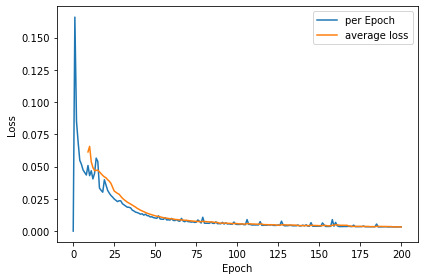

In [ ]:
lstmModel_pseudoRange = HybridLSTMModel(input_size=dimInputs,
                        hidden_size=dimHiddenState,
                        batch_first=True)
lstmModel_pseudoRange.to(device)
lstmModel_pseudoRange.train()
optimizer = torch.optim.Adam(lstmModel_pseudoRange.parameters(),lr=learning_rate) #optimizer
criterion = torch.nn.MSELoss() # loss

lambda_lr = lambda epoch: 10 if 0<=epoch<15 else 1 if 15<=epoch<90 else 0.95
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer,lambda_lr) 

iterSanityCheck = 0

# Create first hidden and cell state with batch=1 
hn = torch.zeros(1, batch_size, dimHiddenState).to(device)  #[num_layers*num_directions,batch,hidden_size]
cn = torch.zeros(1, batch_size, dimHiddenState).to(device)  #[num_layers*num_directions,batch,hidden_size]

training_losses_epoch = [0]
avg_training_loss_epoch = 0

with notebook.tqdm(range(epochs)) as pbar01:
    for epoch in pbar01:
        training_losses_miniBatch = []
        iterSanityCheck = 0
        with notebook.tqdm(dataloader_train, leave=False) as pbar02:
            for svCount, feature, target in pbar02:
                feature = feature.to(device)
                target = target.to(device)
                _, feature = reshape_justify_pack(svCount, feature, dimInputs)

                target_pseudoRange = target[:,:,:,0].view(-1, 1)
                target_pseudoRange = justify_tensor(target_pseudoRange, svCount.sum().sum())

                optimizer.zero_grad()
                out_batched, (hn, cn) = lstmModel_pseudoRange(feature)
                loss = criterion(out_batched, target_pseudoRange)
                
                loss.backward()     # Backward
                optimizer.step()    # gradient descent on adam step
                
                # print(epoch, optimizer.state_dict()['param_groups'][0]['lr'])
                training_losses_miniBatch.append(loss.detach().cpu().numpy())
                pbar02.set_description(f"Mean training loss (perMiniBatch, perEpoch): {np.mean(training_losses_miniBatch[:]):.04f}, {avg_training_loss_epoch:.04f}, {optimizer.state_dict()['param_groups'][0]['lr']}")
                
                if feature.data.shape[0] != svCount.sum().sum():
                    # print(feature.data.shape, svCount, exception_feature.shape)
                    print("number of SVs don't match in this minibatch")
                    break

                # iterSanityCheck +=1
                # if iterSanityCheck == 10:
                #     break
            lr_scheduler.step() # learning rate schedule using lambda function
            # Print training statistics
            training_losses_epoch.append(np.mean(training_losses_miniBatch))
            avg_training_loss_epoch = np.mean(training_losses_epoch[-10:])
            pbar01.set_description(f"Mean training loss (perMiniBatch, perEpoch, lr): {np.mean(training_losses_miniBatch):.04f}, {avg_training_loss_epoch:.04f}, {optimizer.state_dict()['param_groups'][0]['lr']}")
plt.plot(training_losses_epoch, label="per Epoch")
plt.plot(pd.DataFrame(training_losses_epoch).rolling(10).mean(), label="average loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()

if epochs>50:
    germany = timezone('Europe/Berlin')
    de_time = datetime.now(germany).strftime("%m_%d_%y-%H_%M_%S")

    save_path = path / de_time[:-3]
    save_path.mkdir(exist_ok=True)
    save_model_pseudoRange = save_path / ('lstmModel_pseudoRange-' + de_time +'.pt')

    train_fig_save_loc = save_path / ('train_loss-' + de_time + '.png')
    # plt.savefig('training_loss.png', dpi=300)
    plt.savefig(train_fig_save_loc, dpi=300)

    with open(save_model_pseudoRange, "wb") as f:
        torch.save(lstmModel_pseudoRange, f)
        print("Saved model to GDrive path: \n", str(save_model_pseudoRange))

else:
    print("Model not saved since Epoch < 50")


In [ ]:
lstmModel_pseudoRange.eval()
eval_batch_size = 1
dataloader_test = DataLoader(test_set, batch_size=eval_batch_size)

test_loss_tracked = np.zeros((len(dataloader_test.dataset)//eval_batch_size, maxSVID+1))
test_ref_pseudoRange = np.zeros_like(test_loss_tracked)
test_pred_pseudoRange = np.zeros_like(test_loss_tracked)

test_loss_tracked[:] = np.nan
test_ref_pseudoRange[:] = np.nan
test_pred_pseudoRange[:] = np.nan

test_iterations = len(dataloader_test.dataset)//eval_batch_size
iterSanityCheck = 0

test_losses_miniBatch = []
with torch.no_grad():
    with tqdm(dataloader_test) as pbar:
        for idx, (svCount, feature, target) in enumerate(pbar):         
            svIDs, feature = reshape_justify_pack(svCount, feature, dimInputs)  
            svCount = svCount.squeeze()

            feature = feature.to(device)
            target_pseudoRange = target[:,:,:,0].view(-1, 1).to(device)
            target_pseudoRange = justify_tensor(target_pseudoRange, svCount.sum())
            
            out_batched, (hn, cn) = lstmModel_pseudoRange(feature)
            loss_batched = out_batched - target_pseudoRange
            
            loss_batched = loss_batched[-svCount[-1]:].squeeze().cpu().numpy()
            
            svIDs = svIDs.squeeze()[-maxSVs:]
            svIDs = svIDs[~torch.isnan(svIDs)].numpy().astype(int)
            
            test_loss_tracked[idx, svIDs] = loss_batched
            test_ref_pseudoRange[idx, svIDs] = target_pseudoRange[-svCount[-1]:].squeeze().cpu().numpy()
            test_pred_pseudoRange[idx, svIDs] = out_batched[-svCount[-1]:].squeeze().cpu().numpy()

            if test_ref_pseudoRange[idx].min() < -3.0:
                print(idx)
                print(test_ref_pseudoRange[idx].min())
                break
 


            test_losses_miniBatch.append(np.mean(loss_batched))
            
            pbar.set_description(f"Mean test loss (perMiniBatch): {np.mean(test_losses_miniBatch[-10:]):.03f}")
            # iterSanityCheck +=1
            # if iterSanityCheck == 1:
            #     break


Mean test loss (perMiniBatch): -0.137: 100%|██████████| 8238/8238 [01:04<00:00, 126.95it/s]


Plot saved in GDrive: 
 /content/drive/MyDrive/Colab_Notebooks/HiWi/results/model3/08_25_22-23_09/test_loss-08_25_22-23_09_51.png


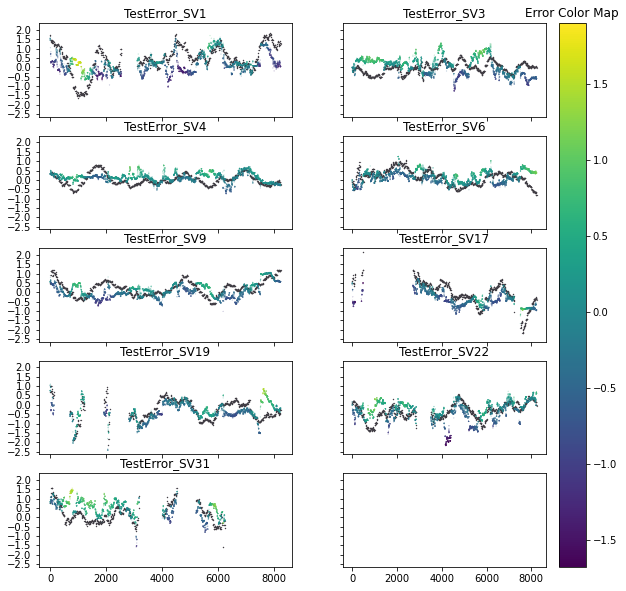

In [ ]:
column_names_test = ['TestError_SV'+svid for svid in svIDList.astype(str)]
column_names_ref = ['Reference_SV'+svid for svid in svIDList.astype(str)]
column_names_pred = ['Prediction_SV'+svid for svid in svIDList.astype(str)]

dfTestError = pd.DataFrame(test_loss_tracked[:,svIDList], columns=column_names_test)
dfRefPseudoRange = pd.DataFrame(test_ref_pseudoRange[:,svIDList], columns=column_names_ref)
dfPredPseudoRange = pd.DataFrame(test_pred_pseudoRange[:,svIDList], columns=column_names_pred)


subplot_rows = len(dfTestError.columns)//2 + 1

cmap = plt.get_cmap("viridis")
norm = plt.Normalize(dfTestError.min().min(), dfTestError.max().max())

fig, axs = plt.subplots(subplot_rows, 2, sharex=True, sharey=True, figsize=(10, 10))

axs = np.ravel(axs)

for i in range(subplot_rows*2-1):
    axs[i].scatter(dfRefPseudoRange.index,
                   dfRefPseudoRange.iloc[:,i],
                   marker='.',
                   s=0.05,
                   c='#413e45')
    axs[i].scatter(dfPredPseudoRange.index,
                   dfPredPseudoRange.iloc[:,i],
                   marker='.',
                   s=0.05,
                   c=dfTestError.iloc[:,i],
                   norm=norm, 
                   cmap=cmap)
    axs[i].set_title(dfTestError.columns[i])

axs = np.reshape(axs, (subplot_rows, 2))
plt.yticks(np.arange(-2.5, 2.5, step=0.50))

sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axs[:,1])
cbar.ax.set_title("Error Color Map")

test_fig_name = 'test_loss.png'
plt.savefig(test_fig_name, dpi=500)

if epochs>50:
    test_fig_save_loc = save_path / ('test_loss-' + de_time + '.png')
    plt.savefig(test_fig_save_loc, dpi=500)
    print("Plot saved in GDrive: \n", str(test_fig_save_loc))
else:
    print("Plot not saved since Epoch < 50")



In [ ]:
print(dfTestError.min(), '\n', dfTestError.max())
print(dfRefPseudoRange.min(),'\n', dfRefPseudoRange.max())
print(dfPredPseudoRange.min(),'\n', dfPredPseudoRange.max())



In [ ]:
# files.download(train_fig_name)
# files.download(test_fig_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>